# KNN regression models

## K-nearest-neighbors theory

The k-nearest neighbors algorithm, commonly known as $k-NN$, is a non-parametric approach where the response of a data point is determined by the nature of its k-neighbors from the training set. It can be used in both classification and regression settings.

```{tip}
Remark: the higher the parameter k, the higher the bias, and the lower the parameter k, the higher the variance.
```

```{figure} ../media/images/k-nearest-neighbors.png
---
width: 550px
name: k-nn
---
This picture shows the bias-variance trad-off with the knn regressor ([image reference](https://stanford.edu/~shervine/teaching/cs-229/illustrations/k-nearest-neighbors.png?02f80a524bb11e2b7a70b58c9ed3b0f4))
```

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
import sys, os
sys.path.insert(0, '/Users/administrador/Documents/geocean-nz-ss')
data_path = '/Volumes/ToshibaJT/geocean-nz-ss/data'
os.environ["SSURGE_DATA_PATH"] = data_path

# custom
from sscode.config import data_path, default_region_reduced, \
    default_evaluation_metrics, default_location, default_region
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.pca import PCA_DynamicPred
from sscode.knn import KNN_Regression
from sscode.plotting.data import plot_uhslc_locations
from sscode.utils import calculate_relative_winds
from sscode.plotting.config import _figsize
from sscode.plotting.utils import plot_ccrs_nz

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


## Load the data

As always, we load the three used datasets, which are the Moana v2 hindcast nearshore, the CFSR sea-level-pressure fields and winds (u10 and v10) and the UHSLC tgs validators, again setting the `plot` parameter to `False`.

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=(False,False,False),
    load_predictor_files=(True,
        [data_path+'/cfsr/CFSR_MSLP_daily.nc',data_path+'/cfsr/CFSR_WINDs_daily.nc']
    ) # load previously calculated winds
)


 loading previously saved atmospheric data from (True, ['/home/javitausia/Documentos/geocean-nz-ss/data/cfsr/CFSR_MSLP_daily.nc', '/home/javitausia/Documentos/geocean-nz-ss/data/cfsr/CFSR_WINDs_daily.nc']) 


 loading the Moana v2 hindcast data... 


 loading the UHSLC tidal guages... 



## Calculate regional PCA

Now, with the loaded data, we can calculate the regional PCs, so they can be used to reconstruct the storm surge all over New Zealand, using the same atmospheric predictor.

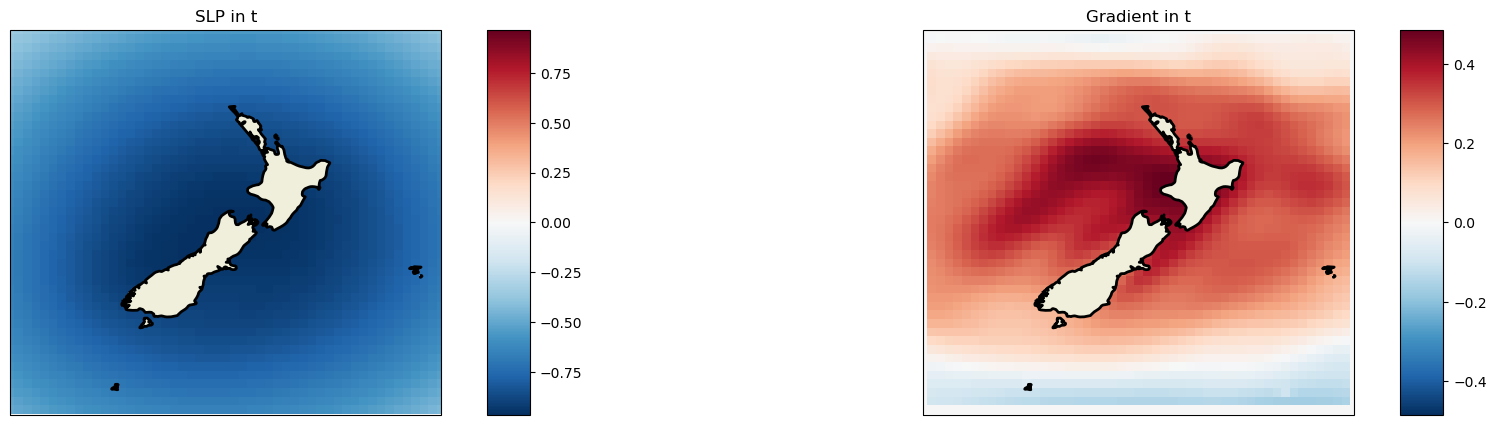

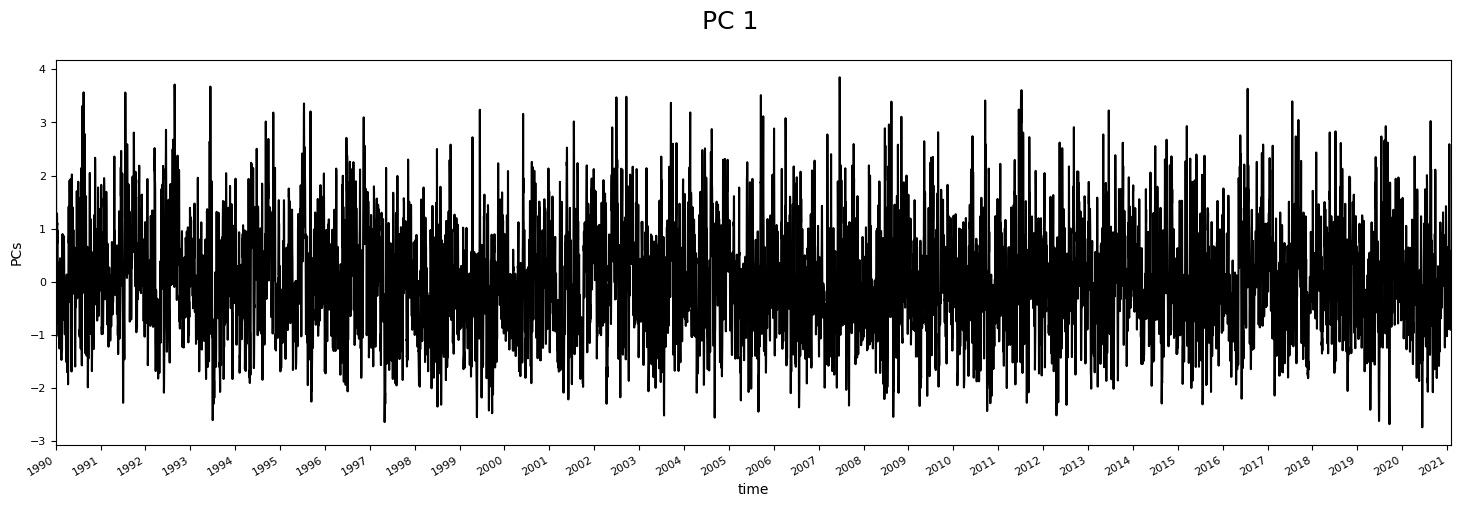

In [3]:
# load / calculate the regional pcs
pcs_data_regional, pcs_scaler_regional = PCA_DynamicPred(
    load_cfsr_moana_uhslc.predictor_slp.SLP, 
    calculate_gradient=True,
    time_lapse=1, # 1 equals to NO time delay                    
    time_resample='1D', # daily resampling
    region=(True,default_region_reduced),
    pca_plot=(True,False,1),
    pca_ttls=('SLP in t','Gradient in t'),
    verbose=False
).pcs_get()

## KNN regression with regional predictor

In the following cell, a knn regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics/knn` folder, with the name `stats_knn_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

This is a snippet of the model outlook:

```python
    # perform the knn regression
    neigh = KNeighborsRegressor() # TODO: add params
    # specify parameters to test
    param_grid = {
        'n_neighbors': np.arange(1,k_neighbors,5),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    # use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(
        neigh, param_grid, cv=cv_folds,
        scoring='explained_variance',
        verbose=1
    ) 
    # TODO: add verbose and cv, DONE!!

    # fit model to data
    knn_gscv.fit(X, y) # input total data
    prediction = knn_gscv.predict(X)
```

where the best number of neighbors is selected, cross-validating the training and testing sizes!!

In [4]:
run = False
if run:
    # perform the KNN-Regression (regional)
    metrics_regional = [] # save regional metrics
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    )[::300]
    # perform the KNN regression over all the sites
    for site in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=site)\
            .load().resample(time='1D').max()
        metrics, model, train_times = KNN_Regression(
            pcs_data_regional, ss_moana, # use default attributes
            verbose=False, plot_results=True
        ) # using the regional-pre-loaded pcs
        metrics_regional.append(list(metrics.values())) # save site metrics
    # now, save all in xarray.Dataset
    sites_metrics_regional = {}
    for im,metric in enumerate(metrics.keys()):
        sites_metrics_regional[metric] = (('site'),np.array(metrics_regional)[:,im])
    sites_metrics_regional['latitude'] = (
        ('site'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat.values
    )
    sites_metrics_regional['longitude'] = (
        ('site'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon.values
    )
    # save the metrics
    metrics_dataset_regional = xr.Dataset(
        sites_metrics_regional,coords={'site':sites_regional}
    )
    # local copys
    if True:
        metrics_dataset_regional.to_netcdf(
            data_path+'/statistics/regional_models/stats_knn_regional_daily.nc'
        ) # save metrics in all the stations
else:
    metrics_dataset_regional = xr.open_dataset(
        data_path+'/statistics/regional_models/stats_knn_regional_daily.nc'
    )

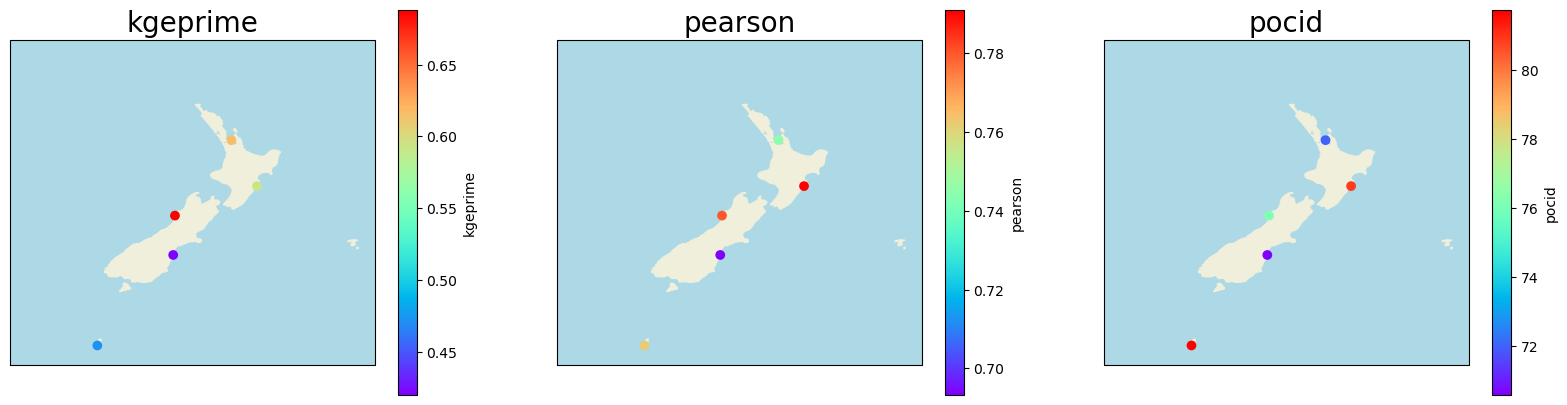

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(metrics_dataset_regional,
               plot_stats=['kgeprime','pearson','pocid'],
               cmap='rainbow')

### KNN regression in the UHSLC tidal gauges + validation

This part explanation is similar to the one available at **MultiLinear regression models (models_linear.ipynb)**!!

But in this case, we could also use the trained agent to see what are the best parameters for our KNN model, in all the locations of the tidal gauges, but training the model with the Moana v2 hindcast.

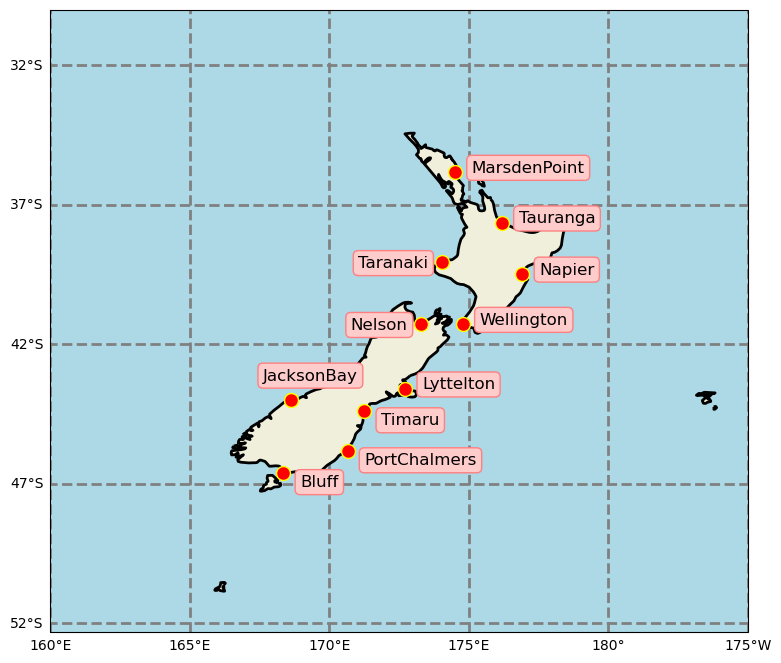

In [6]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)

Assembling matrix
Start 0

 adding the wind to the predictor... 


 winds predictor with shape: 
 (11354, 10, 10) 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 10, 10) 


 calculating PCs matrix with shape: 
 (11351, 900) 

Computing using CPU
matrix (11351, 900)
PCs (11351, 900)
comp (900, 900)
var (900,)
lon <xarray.DataArray 'longitude' (longitude: 10)>
array([166. , 166.5, 167. , 167.5, 168. , 168.5, 169. , 169.5, 170. , 170.5],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 166.0 166.5 167.0 167.5 ... 169.5 170.0 170.5
lat <xarray.DataArray 'latitude' (latitude: 10)>
array([-49. , -48.5, -48. , -47.5, -47. , -46.5, -46. , -45.5, -45. , -44.5],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -49.0 -48.5 -48.0 -47.5 ... -45.5 -45.0 -44.5
time (11351,)

 plotting 1 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



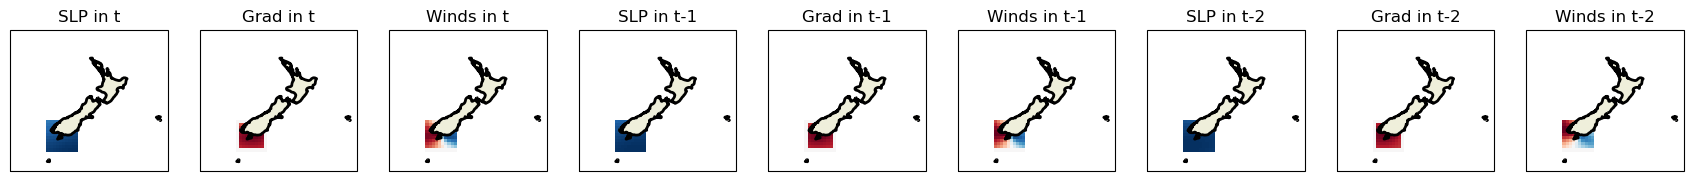

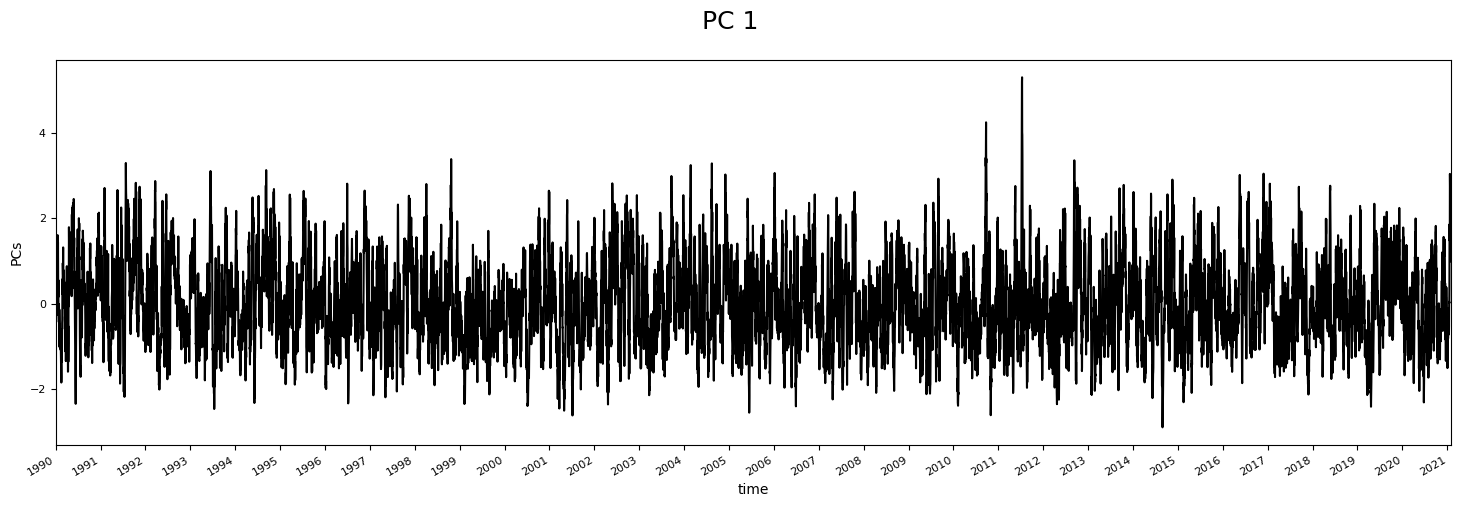


 21 PCs (0.98 expl. variance) will be used to train the model!! 


 KNN regression with 30-max neighbors... 

Fitting 5 folds for each of 29 candidates, totalling 145 fits

 best model fitted with 21 neighbors!! 



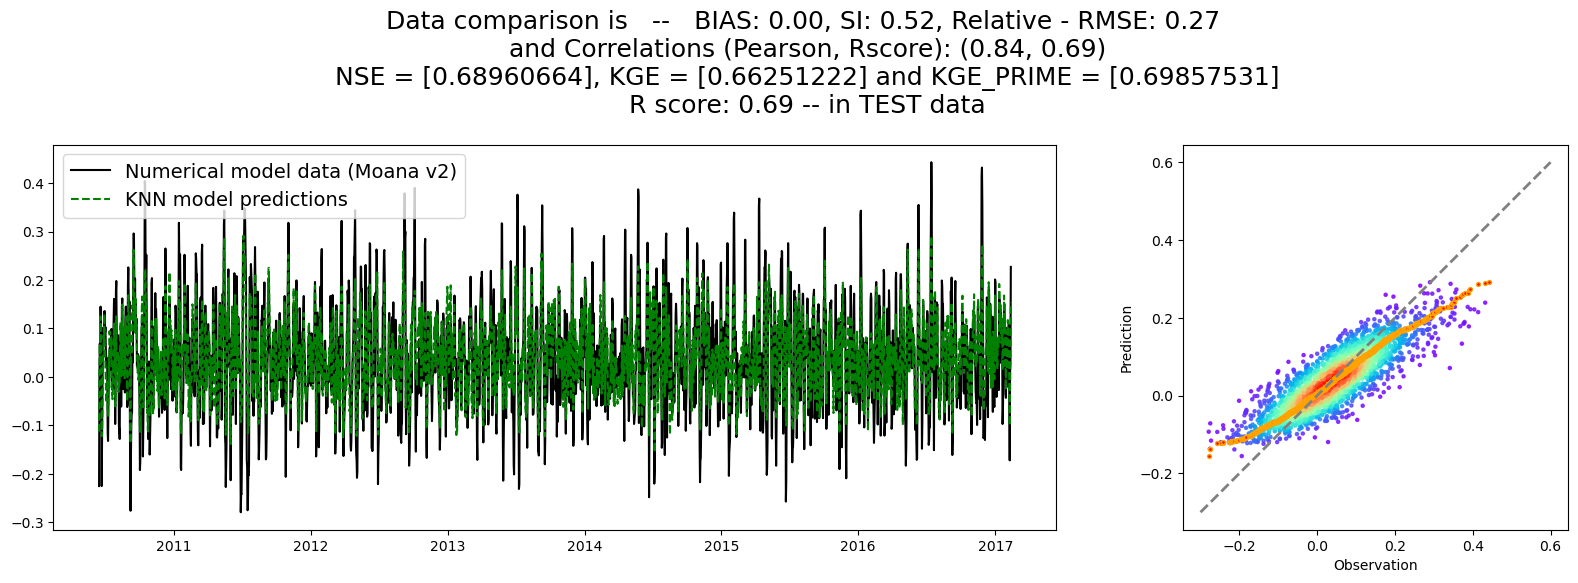

Data comparison is   --   BIAS: 0.00, SI: 0.52, Relative - RMSE: 0.27
 and Correlations (Pearson, Rscore): (0.84, 0.69)
 NSE = [0.68960664], KGE = [0.66251222] and KGE_PRIME = [0.69857531]
 R score: 0.69 -- in TEST data


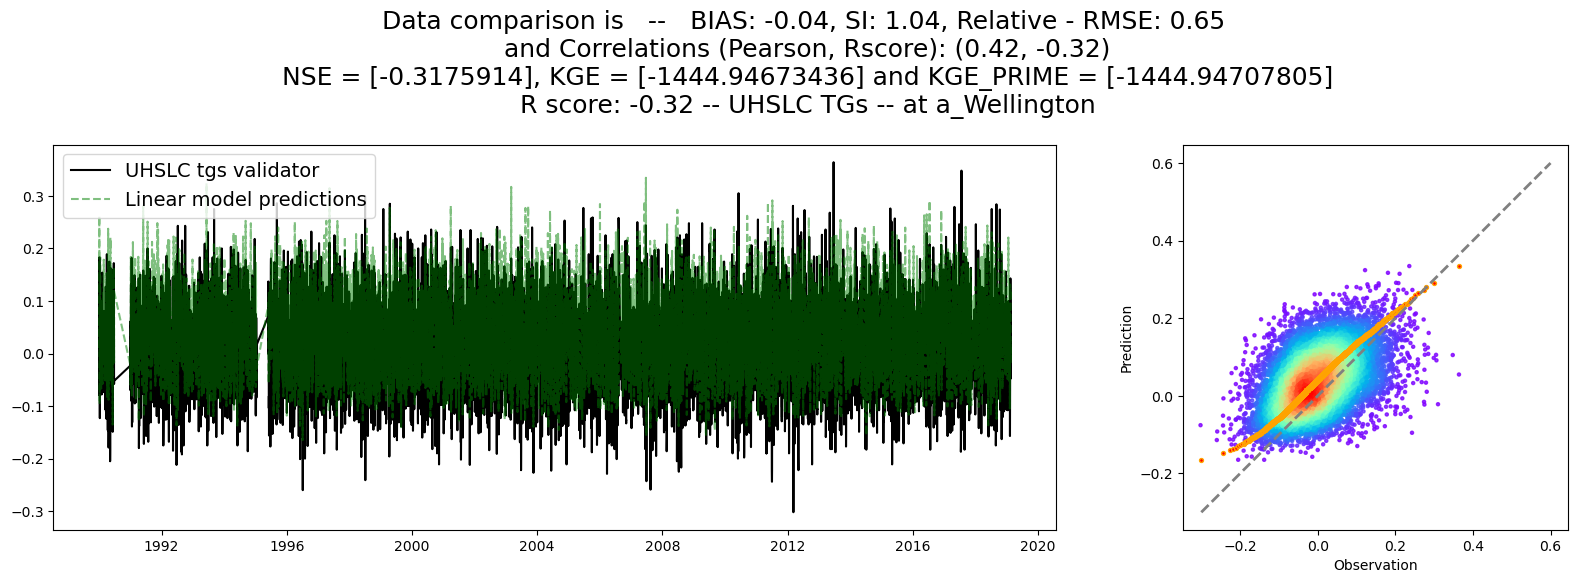

Assembling matrix
Start 0

 adding the wind to the predictor... 


 winds predictor with shape: 
 (11354, 10, 10) 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 10, 10) 


 calculating PCs matrix with shape: 
 (11351, 900) 

Computing using CPU
matrix (11351, 900)
PCs (11351, 900)
comp (900, 900)
var (900,)
lon <xarray.DataArray 'longitude' (longitude: 10)>
array([176. , 176.5, 177. , 177.5, 178. , 178.5, 179. , 179.5, 180. , 180.5],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 176.0 176.5 177.0 177.5 ... 179.5 180.0 180.5
lat <xarray.DataArray 'latitude' (latitude: 10)>
array([-40. , -39.5, -39. , -38.5, -38. , -37.5, -37. , -36.5, -36. , -35.5],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -40.0 -39.5 -39.0 -38.5 ... -36.5 -36.0 -35.5
time (11351,)

 plotting 1 components with 9 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



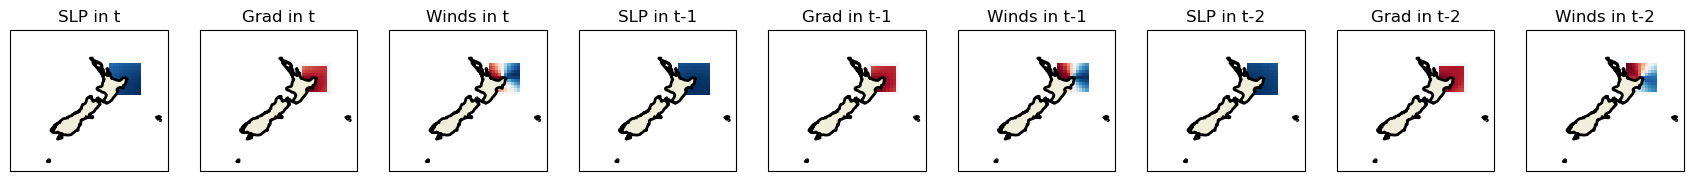

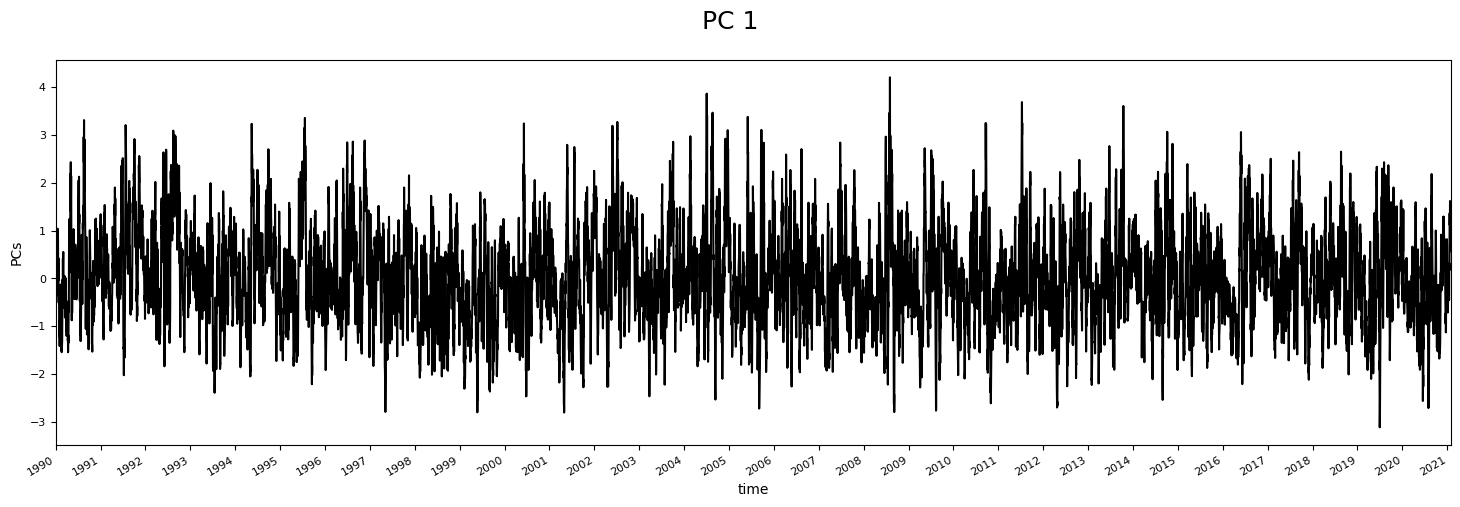


 24 PCs (0.98 expl. variance) will be used to train the model!! 


 KNN regression with 30-max neighbors... 

Fitting 5 folds for each of 29 candidates, totalling 145 fits

 best model fitted with 19 neighbors!! 



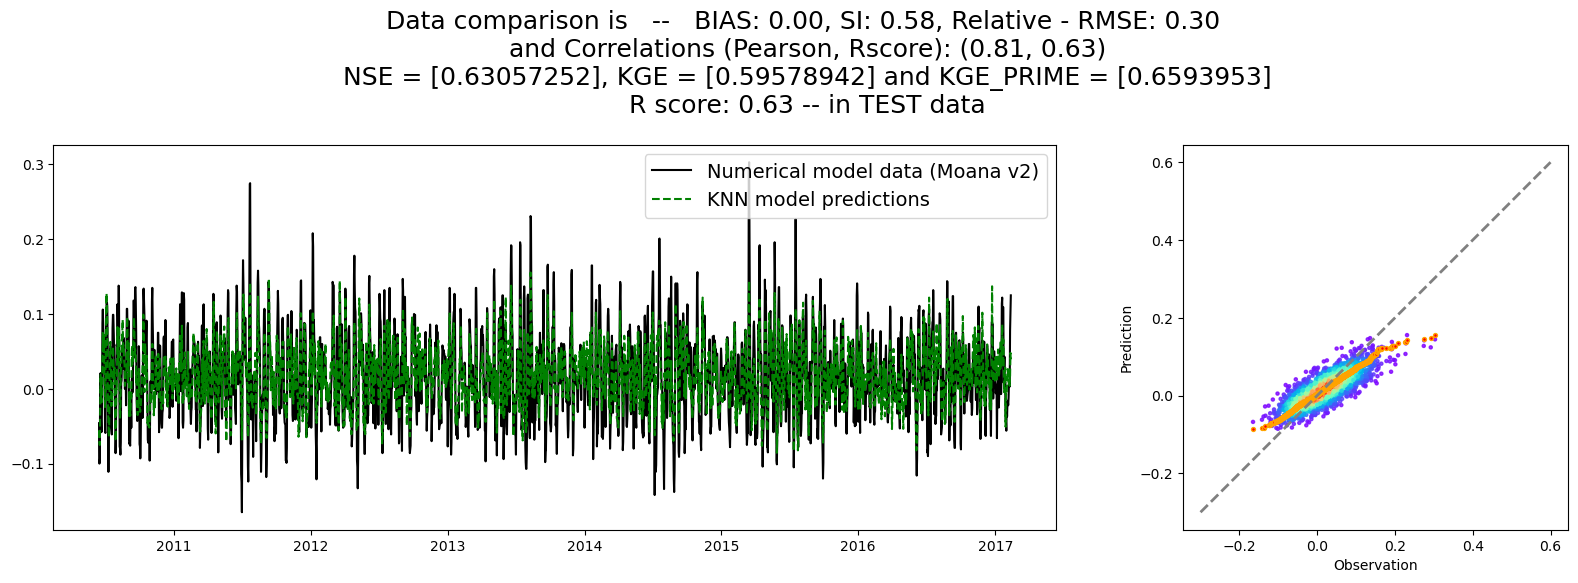

Data comparison is   --   BIAS: 0.00, SI: 0.58, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.81, 0.63)
 NSE = [0.63057252], KGE = [0.59578942] and KGE_PRIME = [0.6593953]
 R score: 0.63 -- in TEST data


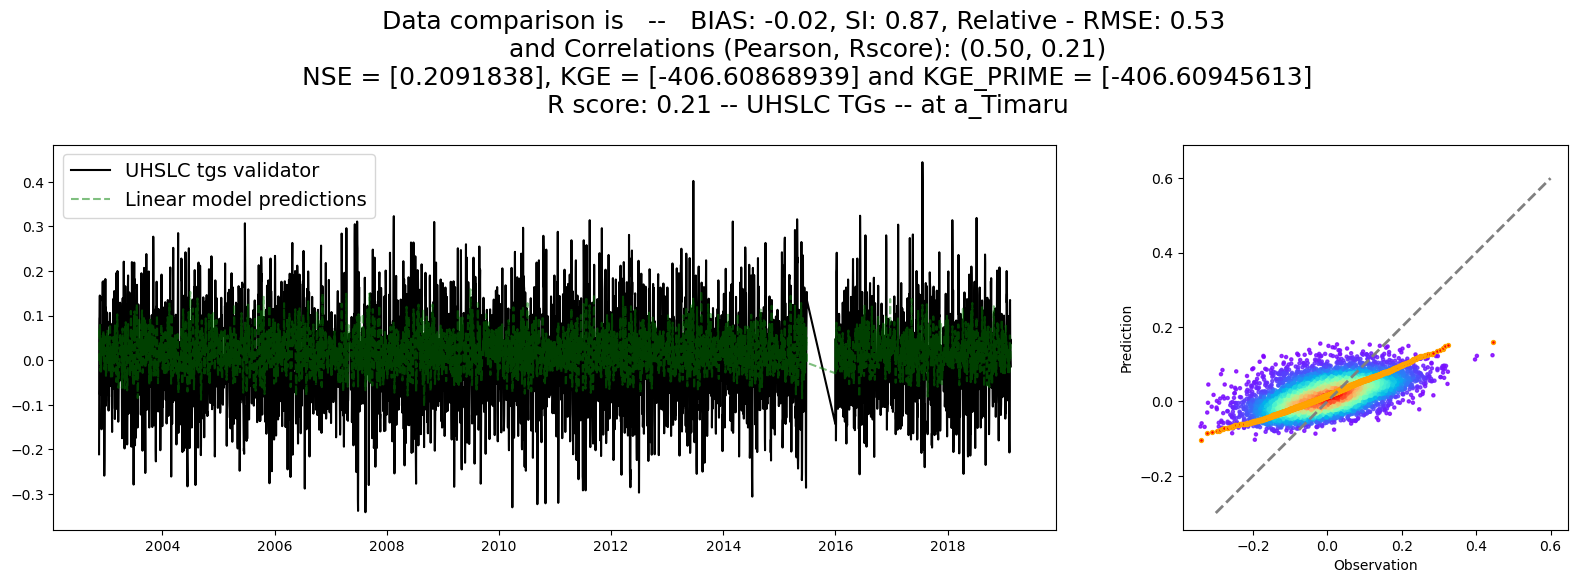

In [9]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
sites_to_analyze = np.unique( # closest Moana v2 Hindcast to tidal gauges
    [ 689,328,393,1327,393,480,999,116,224,1124,949,708, # UHSLC
      1296,378,1124,780,613,488,1442,1217,578,200,1177,1025,689,949,224,1146, # LINZ
      1174,1260,1217,744,1064,1214,803,999 # OTHER (ports...)
    ]
)[::20]
for istat,stat in enumerate(sites_to_analyze):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    metrics, model, train_times = KNN_Regression(
        PCA_DynamicPred(
            load_cfsr_moana_uhslc.predictor_slp.SLP, 
            calculate_gradient=True, time_lapse=3,
            wind=load_cfsr_moana_uhslc.predictor_wind,
            site_location=(ss_moana.lon.values[0],ss_moana.lat.values[0]),
            region=(True, (
                ss_moana.lon.values[0]-2.5,
                ss_moana.lon.values[0]+2.5,
                ss_moana.lat.values[0]-2.5,
                ss_moana.lat.values[0]+2.5
            )),
            pca_plot=(True,False,1), verbose=True,
            pca_ttls=['SLP in t','Grad in t','Winds in t',
                      'SLP in t-1','Grad in t-1','Winds in t-1',
                      'SLP in t-2','Grad in t-2','Winds in t-2']
            ).pcs_get()[0],
        ss_moana, percentage_PCs=0.98, plot_results=True, verbose=True,
        model_metrics=default_evaluation_metrics, train_size=0.7,
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        )
)

### Check KNN reconstructions

Now, we visualize how the knn algorithm works in the prediction task...

```{warning}
TODO: add explanations!!
```

Below, the code used to plot KNN predictions, comparing this prediction with the real data, can be seen:

```python
    # find similarities between real and kneighbors
    n_times = 2 # number of validations/plots
    k_neighbors = 1 # number of neighbors to search
    # plotting fig and axes
    for time in np.random.randint(0,len(train_times),n_times):
        fig, axes = plt.subplots(
            ncols=3,figsize=_figsize,
            subplot_kw={
                'projection':ccrs.PlateCarree(
                    central_longitude=default_location[0]
                )
            }
        )
        real = load_cfsr_moana_uhslc.predictor_slp.isel(time=time)
        real.plot(
            cmap='bwr',vmin=101300-2000,vmax=101300+2000,ax=axes[0],
            transform=ccrs.PlateCarree()
        )
        predicted = load_cfsr_moana_uhslc.predictor_slp.isel(
            time=model.kneighbors(
                pcs_cfsr.isel(time=time).PCs[:388].values.reshape(1,-1),
                # TODO: edit pcs limit above if error is raised!!
                k_neighbors
            )[1][0]
        ).mean(dim='time')
        predicted.plot(
            cmap='bwr',vmin=101300-2000,vmax=101300+2000,ax=axes[1],
            transform=ccrs.PlateCarree()
        )
        (real-predicted).plot(
            cmap='bwr',vmin=-2000,vmax=+2000,ax=axes[2],
            transform=ccrs.PlateCarree()
        )
        axes[1].set_title('Predicted SLP - k_neigh = {}'.format(k_neighbors))
        axes[2].set_title('SLP difference in [mbar·100]')
        plot_ccrs_nz(axes,plot_region=(True,default_region),plot_land=False,
                     plot_labels=(False,None,None))
```